# Backend Location

In [1]:
import os
import numpy as np
import pandas as pd
import datetime

#implemented
from src.backend.api_wrapper import getData

In [2]:
#helper
def dist2DDeg_KM(x,y):
    """
        Approx distance
    """
    dLon =x["lon"]-y["latitude"]
    dLat =x["lat"]-y["longitude"]
    return dLat*111.32+(40075*np.cos(dLat)/360) *dLon


## input

In [3]:
#Input:
startLocation = "Zürich HB"
starting_time = datetime.datetime.fromisoformat('2021-10-30T12:02:00.036331')

destination = "Ilanz" #None
destination = "Zug"
destination_radius = 10000

suprise:bool = False
    
experience = None

In [4]:
#Meta Statistics
loss_data = {}

## retrieve Data

In [5]:
oa = getData.outdoor_active()
js = getData.journey_service()
timetable = getData.timetable_info()
weather = getData.weather_forcast()


In [6]:
#Get starting Info
startLocation_OBJ = timetable.get_locationRequest(location=startLocation)[0]
startLocation_ID = startLocation_OBJ["id"]

destination_OBJ = timetable.get_locationRequest(location=destination)[0]
destination_ID = destination_OBJ["id"]
destination_OBJ


{'id': 8509171,
 'name': 'Ilanz',
 'coordinates': {'latitude': 46.775352, 'longitude': 9.207435},
 'type': 'STATION',
 'tariffBorder': False,
 'weight': 5514,
 'vehicleTypes': ['TRAIN'],
 'links': []}

In [7]:
oa_df = oa.get_dataframe_of_ch(getData.get_coords_request(lat=destination_OBJ["coordinates"]['latitude'], 
                                                          lon=destination_OBJ["coordinates"]['longitude']),
                                                          radius=destination_radius)

In [8]:
oa_df.columns

Index(['lineOptions', 'time', 'length', 'elevation', 'rating', 'labels',
       'startingPoint', 'season', 'startingPointDescr', 'directions', 'tip',
       'destination', 'properties', 'elevationProfile', 'wayType',
       'difficulties', 'category', 'title', 'localizedTitle', 'shortText',
       'longText', 'primaryImage', 'geometry', 'images', 'regions',
       'winterActivity', 'meta', 'id', 'type', 'frontendtype', 'ranking',
       'additionalInformation', 'bookWorks', 'avalancheRegions',
       'publicTransit', 'gettingThere', 'parking', 'safetyGuidelines',
       'equipment', 'pois', 'currentConditions', 'opened'],
      dtype='object')

In [9]:
oa_df["startingPoint"]

0                     {'lon': 9.20795, 'lat': 46.77519}
1                   {'lon': 9.163202, 'lat': 46.791019}
2           {'lon': 9.281379, 'lat': 46.83425499999999}
3     {'lon': 9.286929999999998, 'lat': 46.836609999...
4     {'lon': 9.11721467971802, 'lat': 46.7371106576...
5     {'lon': 9.265120000000001, 'lat': 46.819779999...
6     {'lon': 9.19976234436035, 'lat': 46.7711441794...
7                       {'lon': 9.257, 'lat': 46.80641}
8                     {'lon': 9.14231, 'lat': 46.75779}
9     {'lon': 9.288713999999999, 'lat': 46.825633999...
10          {'lon': 9.29144, 'lat': 46.827516999999986}
11           {'lon': 9.20795, 'lat': 46.77523999999998}
12    {'lon': 9.288789999999999, 'lat': 46.825689999...
13                    {'lon': 9.26426, 'lat': 46.81952}
14          {'lon': 9.273401, 'lat': 46.77028299999999}
15          {'lon': 9.083812, 'lat': 46.74631900000001}
16         {'lon': 9.180314, 'lat': 46.842182999999984}
17    {'lon': 9.114146999999999, 'lat': 46.78488

In [10]:
oa_df.rating[0]

{'condition': 6,
 'difficulty': 3,
 'technique': 4,
 'qualityOfExperience': 0,
 'landscape': 6}

In [11]:
oa_df.shape

(22, 42)

### Outdoor Activity convenvience Metric

#### Get all close stations to the hikes

In [12]:
oa_df_path = "oa_df_withStations.obj"
if(os.path.exists(oa_df_path)):
    oa_df = pd.read_pickle("oa_df_withStations.obj")
else:
    oa_df['closeStations'] = oa_df.apply(lambda x: js.get_locationRequestByCoords(getData.get_coords_request(**x['startingPoint'])), axis=1)
    oa_df.to_pickle(oa_df_path)
oa_df.shape

(22, 43)

In [13]:
oa_df['closeStations']

0     [{'type': 'STATION', 'uicOrId': '8575120', 'na...
1     [{'type': 'STATION', 'uicOrId': '8509879', 'na...
2     [{'type': 'STATION', 'uicOrId': '8509164', 'na...
3     [{'type': 'STATION', 'uicOrId': '8509773', 'na...
4                                                    []
5     [{'type': 'STATION', 'uicOrId': '8509983', 'na...
6     [{'type': 'STATION', 'uicOrId': '8574991', 'na...
7     [{'type': 'STATION', 'uicOrId': '8509786', 'na...
8     [{'type': 'STATION', 'uicOrId': '8509306', 'na...
9     [{'type': 'STATION', 'uicOrId': '8509774', 'na...
10    [{'type': 'STATION', 'uicOrId': '8582910', 'na...
11    [{'type': 'STATION', 'uicOrId': '8575120', 'na...
12    [{'type': 'STATION', 'uicOrId': '8509774', 'na...
13    [{'type': 'STATION', 'uicOrId': '8509983', 'na...
14                                                   []
15    [{'type': 'STATION', 'uicOrId': '8575000', 'na...
16                                                   []
17    [{'type': 'STATION', 'uicOrId': '8509753',

#### Get closest station to the hikes

In [14]:
#clean empty stations:
f_oa_df = oa_df
drop_empty_stations = [i for i, row in oa_df.iterrows() if(len(row['closeStations'])==0)]

loss_noStation = f_oa_df.iloc[drop_empty_stations]
f_oa_df=f_oa_df.drop(index=drop_empty_stations)

loss_data.update({"noStation":loss_noStation})

f_oa_df.shape

(18, 43)

In [15]:
next_station = []
next_station_d = []
closeStations = []
for i, row in f_oa_df.iterrows():
        stations = row['closeStations']
        close_stations_distances = [dist2DDeg_KM(row['startingPoint'],station['coordinatesWGS84'])/1000 for station in stations]
        closest_station_i = np.argmin(close_stations_distances)
        closest_station_dmin = np.min(close_stations_distances)
        closest_station = row['closeStations'][closest_station_i]
        
        #Add info to closeStations
        #print(row['closeStations'],)
        [station.update({"distanceToOA": dist}) for station, dist in zip(stations, close_stations_distances)]
        closeStations.append(stations)

        next_station.append(closest_station)
        next_station_d.append(closest_station_dmin)
        #print("closest_station: ",closest_station_i, closest_station_dmin)
#print(len(close_stations))
f_oa_df["nextStation"] = pd.Series(next_station) 
f_oa_df["nextStation_d"] = pd.Series(next_station_d) 
f_oa_df["closeStations"] = pd.Series(closeStations) 

f_oa_df.dropna(how='all', inplace=True)
f_oa_df.dropna(subset=["closeStations"], inplace=True)

f_oa_df.shape

(15, 45)

In [16]:
closest_station

{'type': 'STATION',
 'uicOrId': '8575050',
 'name': 'Riein, vitg',
 'coordinatesWGS84': {'longitude': 9.233764,
  'latitude': 46.744474,
  'latitudeDecimalDegrees': 46.744474,
  'longitudeDecimalDegrees': 9.233764},
 'cantonCH': 'GR',
 'distance': 7,
 'categories': [],
 'vehicleTypes': ['BUS'],
 'weight': 93,
 'destinationTrends': None,
 'tariffBorderPoint': False,
 'distanceToOA': 0.07391517545079114}

In [17]:
f_oa_df

,lineOptions,time,length,elevation,rating,labels,startingPoint,season,startingPointDescr,directions,...,gettingThere,parking,safetyGuidelines,equipment,pois,currentConditions,opened,closeStations,nextStation,nextStation_d
0,{'strokeColor': '#8b5831'},{'min': 435},73447.000000,"{'ascent': 1804, 'descent': 1804, 'minAltitude...","{'condition': 6, 'difficulty': 3, 'technique':...",{'top': True},"{'lon': 9.20795, 'lat': 46.77519}","{'jan': False, 'feb': False, 'mar': False, 'ap...","Ilanz, Bahnhof",Ilanz - Valendas - Versam - Safien Platz - Saf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'type': 'STATION', 'uicOrId': '8575120', 'na...","{'type': 'STATION', 'uicOrId': '8575019', 'nam...",0.030952
1,{'strokeColor': '#2e5676'},{'min': 180},9984.000000,"{'ascent': 1048, 'descent': 1048, 'minAltitude...","{'condition': 2, 'difficulty': 1, 'technique':...",{'top': True},"{'lon': 9.163202, 'lat': 46.791019}","{'jan': True, 'feb': True, 'mar': True, 'apr':...","Siat, Bushaltestelle",Dalpaleus - Runvagau,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'type': 'STATION', 'uicOrId': '8509879', 'na...","{'type': 'STATION', 'uicOrId': '8575097', 'nam...",0.010281
2,{'strokeColor': '#9e324a'},{'min': 120},7682.000000,"{'ascent': 36, 'descent': 36, 'minAltitude': 1...","{'condition': 2, 'difficulty': 1, 'technique':...",{'top': True},"{'lon': 9.281379, 'lat': 46.83425499999999}","{'jan': False, 'feb': False, 'mar': False, 'ap...","Flims, Talstation Sessellift Foppa",Flims - Foppa - Uaul Steina - Muletg - Runca S...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'type': 'STATION', 'uicOrId': '8509164', 'na...","{'type': 'STATION', 'uicOrId': '8582908', 'nam...",0.042262
3,{'strokeColor': '#8b5831'},{'min': 255},29476.000000,"{'ascent': 1492, 'descent': 1492, 'minAltitude...","{'condition': 6, 'difficulty': 3, 'technique':...",{'top': True},"{'lon': 9.286929999999998, 'lat': 46.836609999...","{'jan': False, 'feb': False, 'mar': False, 'ap...","Flims, Post",Flims - Crestasee - Trin Mulin - Trin - Alp Mo...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'type': 'STATION', 'uicOrId': '8509773', 'na...","{'type': 'STATION', 'uicOrId': '8582907', 'nam...",0.042927
5,{'strokeColor': '#8b5831'},{'min': 330},33789.705872,"{'ascent': 1614, 'descent': 1614, 'minAltitude...","{'condition': 5, 'difficulty': 3, 'technique':...",NaN,"{'lon': 9.265120000000001, 'lat': 46.819779999...","{'jan': False, 'feb': False, 'mar': False, 'ap...","Flims, Talstation Gondelbahn Crap Sogn Gion",Murschetg - Falera - Station Crap Sogn Gion - ...,...,NaN,NaN,NaN,NaN,NaN,{'currentCondition': [{'id': '64024538'}]},False,"[{'type': 'STATION', 'uicOrId': '8574991', 'na...","{'type': 'STATION', 'uicOrId': '8557046', 'nam...",0.030110
6,{'strokeColor': '#4134b3'},{'min': 150},6186.598111,"{'ascent': 380, 'descent': 380, 'minAltitude':...","{'condition': 3, 'difficulty': 2, 'technique':...",NaN,"{'lon': 9.19976234436035, 'lat': 46.7711441794...","{'jan': True, 'feb': True, 'mar': False, 'apr'...",Flond,Wir gehen die Alte Flonderstrasse ca. bis wir ...,...,Von Chur aus kommend fahren wir auf der E43 Ri...,Parkmöglichkeiten in Ilanz nutzen.,Auf entgegenkommende Schlitelfahrer bzw. Fussg...,NaN,NaN,NaN,NaN,"[{'type': 'STATION', 'uicOrId': '8509786', 'na...","{'type': 'STATION', 'uicOrId': '8575015', 'nam...",0.043105
7,{'strokeColor': '#8b5831'},{'min': 315},34638.351650,"{'ascent': 1919, 'descent': 1919, 'minAltitude...","{'condition': 6, 'difficulty': 3, 'technique':...",NaN,"{'lon': 9.257, 'lat': 46.80641}","{'jan': False, 'feb': False, 'mar': False, 'ap...",Parkplatz beim See in Laax,Parkplatz Laax - Mulin - Talsation Laax - Alp ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'type': 'STATION', 'uicOrId': '8509306', 'na...","{'type': 'STATION', 'uicOrId': '8509694', 'nam...",0.012864
8,{'strokeColor': '#8b5831'},{'min': 225},31539.037606,"{'ascent': 1175, 'descent': 1175, 'minAltitude...","{'condition': 4, 'difficulty': 2, 'technique':...",NaN,"{'lon': 9.14231, 'lat': 46.75779}","{'jan': False, 'feb': False, 'mar': False, 'ap...",Post 

#### get travel route

In [42]:
#Travel Time and changes
def get_fastest_trip(destinationStation_ID, startLocation_ID, starting_time):
    trip_request = getData.generate_trip_dict(originId=startLocation_ID,
                                              destinationId=destinationStation_ID,
                                              date=starting_time.date(),
                                              time=starting_time.time())
    trips = timetable.get_tripRequest(trip_request)
    if(len(trips) == 0):
        return np.nan
    else:
        t_deltas = []
        segments = []
        for trip in trips:
            start_time = datetime.datetime.fromisoformat(trip['segments'][0]['stops'][0]['departureDateTime'])
            end_time = datetime.datetime.fromisoformat(trip['segments'][-1]['stops'][-1]["arrivalDateTime"])
            deltaT = end_time-start_time
            segments.append(len(trip['segments']))
            t_deltas.append(deltaT.seconds)

        t_deltas = np.array(t_deltas)
        segments = np.array(segments)
        
        fastest_trip_i = np.argmin(t_deltas)
        fastest_trip = trips[np.argmin(t_deltas)]
        fastest_trip_t = np.min(t_deltas)
        fastest_trip.update({"t":fastest_trip_t, "nSegments": segments[fastest_trip_i]})
        return fastest_trip
    
trip_oa_df_path = "oa_df_withStations_withTrips.obj"
if(os.path.exists(trip_oa_df_path) and False):
    trip_oa_df = pd.read_pickle(trip_oa_df_path)
else:
    trip_oa_df = f_oa_df
    trip_oa_df["fastestTripToDestination"] = trip_oa_df.apply(lambda x: get_fastest_trip(x["nextStation"]['uicOrId'], startLocation_ID=startLocation_ID, starting_time=starting_time), axis=1)
    trip_oa_df["fastestTripHome"] = trip_oa_df.apply(lambda x: get_fastest_trip(startLocation_ID=startLocation_ID, destinationStation_ID=x["nextStation"]['uicOrId'], starting_time=starting_time+datetime.timedelta(minutes=x["time"]["min"])), axis=1)
    trip_oa_df.dropna(subset=["fastestTripToDestination", "fastestTripHome"], inplace=True)
    trip_oa_df.to_pickle(trip_oa_df_path)
trip_oa_df.shape

(15, 47)

In [79]:
trip_oa_df.dropna(subset=["fastestTripToDestination", "fastestTripHome"], inplace=True)



[6480, 6720, 6720, 7080, 7260, 7260, 7740, 7800, 7860, 7980, 8040, 8340]

In [88]:
trip_oa_df['nextStation']

0     {'type': 'STATION', 'uicOrId': '8575019', 'nam...
1     {'type': 'STATION', 'uicOrId': '8575097', 'nam...
2     {'type': 'STATION', 'uicOrId': '8582908', 'nam...
3     {'type': 'STATION', 'uicOrId': '8582907', 'nam...
5     {'type': 'STATION', 'uicOrId': '8557046', 'nam...
6     {'type': 'STATION', 'uicOrId': '8575015', 'nam...
7     {'type': 'STATION', 'uicOrId': '8509694', 'nam...
8     {'type': 'STATION', 'uicOrId': '8574682', 'nam...
9     {'type': 'STATION', 'uicOrId': '8574681', 'nam...
10    {'type': 'STATION', 'uicOrId': '8575019', 'nam...
11    {'type': 'STATION', 'uicOrId': '8574682', 'nam...
12    {'type': 'STATION', 'uicOrId': '8582903', 'nam...
Name: nextStation, dtype: object

In [80]:
### Extract Features

In [95]:
fastest_trip_time = pd.Series([float(x["fastestTripToDestination"]['t'])/60 for x in trip_oa_df["fastestTripToDestination"]])
nsegments_trip = pd.Series([float(x["fastestTripToDestination"]['nSegments']) for x in trip_oa_df["fastestTripToDestination"]])
last_mileDist = pd.Series([float(x['distanceToOA']) for x in trip_oa_df["nextStation"]])

trip_oa_df["feat_tripTime"] = fastest_trip_time
trip_oa_df["feat_nsegments_trip"] = nsegments_trip
trip_oa_df["feat_lastMile"] = last_mileDist


In [96]:
trip_oa_df.columns

Index(['lineOptions', 'time', 'length', 'elevation', 'rating', 'labels',
       'startingPoint', 'season', 'startingPointDescr', 'directions', 'tip',
       'destination', 'properties', 'elevationProfile', 'wayType',
       'difficulties', 'category', 'title', 'localizedTitle', 'shortText',
       'longText', 'primaryImage', 'geometry', 'images', 'regions',
       'winterActivity', 'meta', 'id', 'type', 'frontendtype', 'ranking',
       'additionalInformation', 'bookWorks', 'avalancheRegions',
       'publicTransit', 'gettingThere', 'parking', 'safetyGuidelines',
       'equipment', 'pois', 'currentConditions', 'opened', 'closeStations',
       'nextStation', 'nextStation_d', 'fastestTripToDestination',
       'fastestTripHome', 'feat_tripTime', 'feat_nsegments_trip',
       'feat_lastMile'],
      dtype='object')

#### judge travel convenience

In [103]:
sortedtrip_oa_df = trip_oa_df.sort_values(by=['feat_tripTime', "feat_lastMile", "feat_nsegments_trip"])
sortedtrip_oa_df

,lineOptions,time,length,elevation,rating,labels,startingPoint,season,startingPointDescr,directions,...,currentConditions,opened,closeStations,nextStation,nextStation_d,fastestTripToDestination,fastestTripHome,feat_tripTime,feat_nsegments_trip,feat_lastMile
0,{'strokeColor': '#8b5831'},{'min': 435},73447.000000,"{'ascent': 1804, 'descent': 1804, 'minAltitude...","{'condition': 6, 'difficulty': 3, 'technique':...",{'top': True},"{'lon': 9.20795, 'lat': 46.77519}","{'jan': False, 'feb': False, 'mar': False, 'ap...","Ilanz, Bahnhof",Ilanz - Valendas - Versam - Safien Platz - Saf...,...,NaN,NaN,"[{'type': 'STATION', 'uicOrId': '8575120', 'na...","{'type': 'STATION', 'uicOrId': '8575019', 'nam...",0.030952,lineOptions ...,{'tripId': 'iQ7wSQoCVjEShwbCtkhLScK2VCRBPTFATz...,108.0,3.0,0.030952
1,{'strokeColor': '#2e5676'},{'min': 180},9984.000000,"{'ascent': 1048, 'descent': 1048, 'minAltitude...","{'condition': 2, 'difficulty': 1, 'technique':...",{'top': True},"{'lon': 9.163202, 'lat': 46.791019}","{'jan': True, 'feb': True, 'mar': True, 'apr':...","Siat, Bushaltestelle",Dalpaleus - Runvagau,...,NaN,NaN,"[{'type': 'STATION', 'uicOrId': '8509879', 'na...","{'type': 'STATION', 'uicOrId': '8575097', 'nam...",0.010281,lineOptions ...,{'tripId': 'jxDwSQoCVjESgQbCtkhLScK2VCRBPTFATz...,112.0,3.0,0.010281
2,{'strokeColor': '#9e324a'},{'min': 120},7682.000000,"{'ascent': 36, 'descent': 36, 'minAltitude': 1...","{'condition': 2, 'difficulty': 1, 'technique':...",{'top': True},"{'lon': 9.281379, 'lat': 46.83425499999999}","{'jan': False, 'feb': False, 'mar': False, 'ap...","Flims, Talstation Sessellift Foppa",Flims - Foppa - Uaul Steina - Muletg - Runca S...,...,NaN,NaN,"[{'type': 'STATION', 'uicOrId': '8509164', 'na...","{'type': 'STATION', 'uicOrId': '8582908', 'nam...",0.042262,lineOptions ...,{'tripId': 'iQ_wSQoCVjESyAfCtkhLScK2VCRBPTFATz...,112.0,3.0,0.042262
3,{'strokeColor': '#8b5831'},{'min': 255},29476.000000,"{'ascent': 1492, 'descent': 1492, 'minAltitude...","{'condition': 6, 'difficulty': 3, 'technique':...",{'top': True},"{'lon': 9.286929999999998, 'lat': 46.836609999...","{'jan': False, 'feb': False, 'mar': False, 'ap...","Flims, Post",Flims - Crestasee - Trin Mulin - Trin - Alp Mo...,...,NaN,NaN,"[{'type': 'STATION', 'uicOrId': '8509773', 'na...","{'type': 'STATION', 'uicOrId': '8582907', 'nam...",0.042927,lineOptions ...,{'tripId': '0_xDwSQoCVjESxQfCtkhLScK2VCRBPTFAT...,118.0,4.0,0.042927
5,{'strokeColor': '#8b5831'},{'min': 330},33789.705872,"{'ascent': 1614, 'descent': 1614, 'minAltitude...","{'condition': 5, 'difficulty': 3, 'technique':...",NaN,"{'lon': 9.265120000000001, 'lat': 46.819779999...","{'jan': False, 'feb': False, 'mar': False, 'ap...","Flims, Talstation Gondelbahn Crap Sogn Gion",Murschetg - Falera - Station Crap Sogn Gion - ...,...,{'currentCondition': [{'id': '64024538'}]},False,"[{'type': 'STATION', 'uicOrId': '8574991', 'na...","{'type': 'STATION', 'uicOrId': '8557046', 'nam...",0.030110,lineOptions ...,{'tripId': 'jA7wSQoCVjEShgbCtkhLScK2VCRBPTFATz...,121.0,4.0,0.043105
6,{'strokeColor': '#4134b3'},{'min': 150},6186.598111,"{'ascent': 380, 'descent': 380, 'minAltitude':...","{'condition': 3, 'difficulty': 2, 'technique':...",NaN,"{'lon': 9.19976234436035, 'lat': 46.7711441794...","{'jan': True, 'feb': True, 'mar': False, 'apr'...",Flond,Wir gehen die Alte Flonderstrasse ca. bis wir ...,...,NaN,NaN,"[{'type': 'STATION', 'uicOrId': '8509786', 'na...","{'type': 'STATION', 'uicOrId': '8575015', 'nam...",0.043105,lineOptions ...,{'tripId': 'gRHwSQoCVjES7gTCtkhLScK2VCRBPTFATz...,129.0,4.0,0.012864
7,{'strokeColor': '#8b5831'},{'min': 315},34638.351650,"{'ascent': 1919, 'descent': 1919, 'minAltitude...","{'condition': 6, 'difficulty': 3, 'technique':...",NaN,"{'lon': 9.257, 'lat': 46.80641}","{'jan': False, 'feb': False, 'mar': False, 'ap...",Parkplatz beim See in Laax,Parkplatz Laax - Mulin - Talsation Laax - Alp ...,...,NaN,NaN,"[{'type': 'STATION', 'uicOrId': '8509306', 'na...","{'type': 'STATION', 'uicOrId': '8

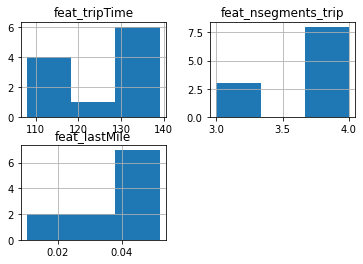

In [115]:
data = trip_oa_df.hist(column=[x for x in trip_oa_df.columns if("feat" in x)], bins=int(np.ceil(trip_oa_df.shape[0]*0.2)))

In [123]:
vars(data[0][0])

{'_stale': True,
 'stale_callback': <function matplotlib.figure._stale_figure_callback(self, val)>,
 '_axes': <AxesSubplot:title={'center':'feat_tripTime'}>,
 'figure': <Figure size 432x288 with 4 Axes>,
 '_transform': None,
 '_transformSet': False,
 '_visible': True,
 '_animated': False,
 '_alpha': None,
 'clipbox': None,
 '_clippath': None,
 '_clipon': True,
 '_label': '',
 '_picker': None,
 '_contains': None,
 '_rasterized': False,
 '_agg_filter': None,
 '_mouseover': False,
 '_callbacks': <matplotlib.cbook.CallbackRegistry at 0x25c51400448>,
 '_remove_method': <bound method FigureBase.delaxes of <Figure size 432x288 with 4 Axes>>,
 '_url': None,
 '_gid': None,
 '_snap': None,
 '_sketch': None,
 '_path_effects': [],
 '_sticky_edges': _XYPair(x=[], y=[]),
 '_in_layout': True,
 '_position': Bbox([[0.125, 0.5517391304347825], [0.4619565217391305, 0.88]]),
 '_originalPosition': Bbox([[0.125, 0.5517391304347825], [0.4619565217391305, 0.88]]),
 '_aspect': 'auto',
 '_adjustable': 'box',
 '

In [141]:
trip_oa_df[[x for x in trip_oa_df.columns if("feat" in x)]].dropna()

,feat_tripTime,feat_nsegments_trip,feat_lastMile
0,108.0,3.0,0.030952
1,112.0,3.0,0.010281
2,112.0,3.0,0.042262
3,118.0,4.0,0.042927
5,121.0,4.0,0.043105
6,129.0,4.0,0.012864
7,130.0,4.0,0.050806
8,131.0,4.0,0.051961
9,133.0,4.0,0.030932
10,134.0,4.0,0.050784


In [140]:
count, division = pd.np.histogram(trip_oa_df[[x for x in trip_oa_df.columns if("feat" in x)]].dropna())


ValueError: autodetected range of [nan, nan] is not finite

### Outdoor Activity Weather metric

In [99]:
destination = trip_oa_df.iloc[0]
weather_request = getData.get_weather_request()#time=starting_time, location=[destination["startingPoint"]["lon"], destination["startingPoint"]["lat"]])
weather.get_weather(weather_request)


token was still valid
2021-10-29T00:00:00+02:00/t_2m:C,relative_humidity_2m:p,wind_speed_10m:ms,precip_1h:mm/47.4245,9.3767/csv

<Response [403]>
Access not allowed: forbidden


IndexError: list index out of range

## Punkte:
* more broad decision for different stations and travelling times
    * decide by distance, segment number, tarveling time
* 

In [ ]:
starting_time.time().strftime('%H:%M')